1. Adat beszerzés, "Big Data" eszközbe betöltése, EDA és dokumentálása
2. Interaktív vizualizáció, hipotézisek megfogalmazása
3. Elemzése feladat és dokumentálása, modell építése és kiértékelése

csv fájlt a notebook-ot tartalmazó mappába kell rakni

In [1]:
import pyspark
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

import json

pd.set_option('display.max_columns', 100)

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import * 
from pyspark.sql.window import Window
from pyspark.sql.functions import *
from pyspark.ml.stat import Correlation

sc = SparkContext.getOrCreate()
spark = SparkSession.builder.appName("Exam task").getOrCreate()

In [2]:
data="globalterrorismdb_0919dist.csv"

In [3]:
df=spark.read.csv(data,header="true", sep=";",inferSchema=True)

In [4]:
df.printSchema()

root
 |-- eventid: long (nullable = true)
 |-- iyear: integer (nullable = true)
 |-- imonth: integer (nullable = true)
 |-- iday: integer (nullable = true)
 |-- approxdate: string (nullable = true)
 |-- extended: integer (nullable = true)
 |-- resolution: string (nullable = true)
 |-- country: integer (nullable = true)
 |-- country_txt: string (nullable = true)
 |-- region: integer (nullable = true)
 |-- region_txt: string (nullable = true)
 |-- provstate: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- specificity: integer (nullable = true)
 |-- vicinity: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- crit1: string (nullable = true)
 |-- crit2: string (nullable = true)
 |-- crit3: string (nullable = true)
 |-- doubtterr: integer (nullable = true)
 |-- alternative: integer (nullable = true)
 |-- alternative_txt: string (nullab

EDA:

1) null, nan értékek keresése (cél változó, koordináták elsődlegesen)

2) egyéb oszlopokban lévő null/nall értékek kiértékelése

3) Kapcsolatok vizualizálás, cél változó ('nkill') klasszifikáláshoz szükséges oszlopok meghatározása

Hipotézisek:

Általában a halálos esetek száma kicsi (<10), vannak extrém esetek (2001 szept. 11.), ennek megfelelően csoportok létrehozása

Kontinens/ország, fegyver illetve a támadás módja fontos befolyásoló tényezők

In [5]:
perc="{:.2%}".format(df.filter(df.nkill.isNull()).count()/df.count())
print(f"Hiányzó értékek százaléka a cél változóban: {perc}")

Hiányzó értékek százaléka a cél változóban: 5.77%


In [6]:
perc="{:.2%}".format(df.filter((df.longitude.isNull()) | (df.latitude.isNull() ) ).count()/df.count())
print(f"Hiányzó értékek százaléka a koordináták esetén: {perc}")

Hiányzó értékek százaléka a koordináták esetén: 2.39%


In [7]:
# Hiányzó értékek százalékának kiszámolása minden oszlopra
na_df= df.select([(count(when(isnull(c), c))/df.count() ).alias(c) for c in df.columns]).toPandas() 

In [8]:
# 70 leghiányosabb oszlop nevének listába mentése, hogy később ki legyenek hagyva
cols_to_ignore=list(na_df.T.sort_values(ascending=False,by=0)[:70].index)

In [9]:
#Sorok kiszűrése, ahol a cél változó nem üres és ennek elmentése egy új dataframebe
cleaned_df=df.na.drop(how="any",subset=["nkill","longitude","latitude"])

#Értékek konvertálása
cleaned_df = cleaned_df.withColumn("nkill",cleaned_df["nkill"].cast(IntegerType())) 
cleaned_df = cleaned_df.withColumn("nkillus",cleaned_df["nkillus"].cast(IntegerType())) 
cleaned_df = cleaned_df.withColumn("nkillter",cleaned_df["nkillter"].cast(IntegerType())) 
cleaned_df = cleaned_df.withColumn("nwound",cleaned_df["nwound"].cast(IntegerType())) 
cleaned_df = cleaned_df.withColumn("nwoundus",cleaned_df["nwoundus"].cast(IntegerType())) 
cleaned_df = cleaned_df.withColumn("nwoundte",cleaned_df["nwoundte"].cast(IntegerType())) 
cleaned_df = cleaned_df.withColumn("ishostkid",cleaned_df["ishostkid"].cast(IntegerType())) 
cleaned_df = cleaned_df.withColumn("multiple",cleaned_df["multiple"].cast(IntegerType())) 

cleaned_df = cleaned_df.withColumn("natlty1",cleaned_df["natlty1"].cast(IntegerType()))

cleaned_df = cleaned_df.withColumn("targtype1",cleaned_df["targtype1"].cast(IntegerType())) 
cleaned_df = cleaned_df.withColumn("targsubtype1",cleaned_df["targsubtype1"].cast(IntegerType())) 

cleaned_df = cleaned_df.withColumn("crit1",cleaned_df["crit1"].cast(IntegerType())) 
cleaned_df = cleaned_df.withColumn("crit2",cleaned_df["crit2"].cast(IntegerType())) 
cleaned_df = cleaned_df.withColumn("crit3",cleaned_df["crit3"].cast(IntegerType())) 

cleaned_df = cleaned_df.withColumn("attacktype1",cleaned_df["targsubtype1"].cast(IntegerType())) 
cleaned_df = cleaned_df.withColumn("attacktype2",cleaned_df["attacktype2"].cast(IntegerType())) 
cleaned_df = cleaned_df.withColumn("attacktype3",cleaned_df["attacktype3"].cast(IntegerType())) 

cleaned_df = cleaned_df.withColumn("ransomamt",cleaned_df["ransomamt"].cast(IntegerType())) 

cleaned_df = cleaned_df.withColumn("targsubtype1",when(cleaned_df["targsubtype1"] == "Unknown", 0).otherwise\
                                   (cleaned_df["targsubtype1"]))

In [10]:
perc="{:.2%}".format(cleaned_df.where(cleaned_df.nkill.isNull()).count()/cleaned_df.count())
print(f"Hiányzó értékek százaléka a cél változóban: {perc}")

Hiányzó értékek százaléka a cél változóban: 0.02%


In [11]:
perc="{:.2%}".format(cleaned_df.filter((cleaned_df.longitude.isNull()) | (cleaned_df.latitude.isNull() ) ).count()/cleaned_df.count())
print(f"Hiányzó értékek százaléka a koordináták esetén: {perc}")

Hiányzó értékek százaléka a koordináták esetén: 0.00%


In [12]:
#néhány null value bent ragadt cél változó esetén, új dataframe generálás
final_df=cleaned_df.where(~cleaned_df.nkill.isNull()) 
final_df=final_df.select([c for c in final_df.columns if c not in cols_to_ignore])
cleaned_df=None

In [13]:
perc="{:.2%}".format(final_df.where(final_df.nkill.isNull()).count()/final_df.count())
print(f"Hiányzó értékek százaléka a cél változóban: {perc}")

Hiányzó értékek százaléka a cél változóban: 0.00%


In [14]:
kills=final_df.select("nkill").toPandas()

<AxesSubplot:>

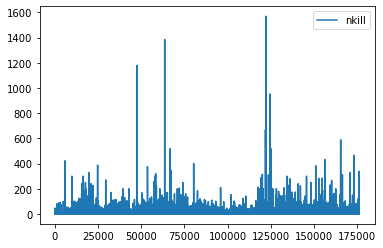

In [15]:
kills.plot()

array([[<AxesSubplot:title={'center':'nkill'}>]], dtype=object)

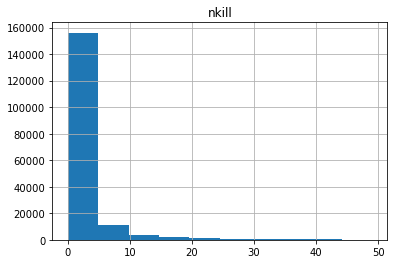

In [16]:
kills[kills<50].hist()

array([[<AxesSubplot:title={'center':'nkill'}>]], dtype=object)

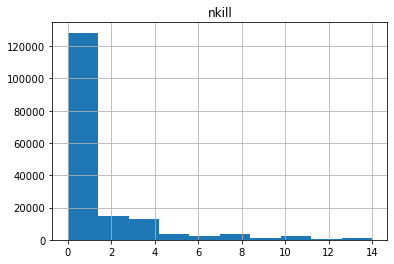

In [17]:
kills[kills<15].hist()

array([[<AxesSubplot:title={'center':'nkill'}>]], dtype=object)

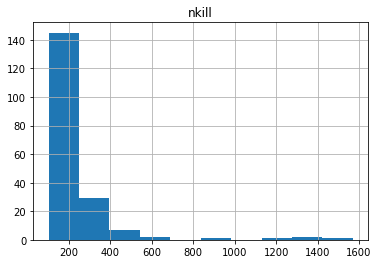

In [18]:
kills[kills>100].hist()

In [19]:
#csoportosításhoz Used Defined Function
def udf_groups(kills): 
    if (kills==0):
        return "Halál eset nélküli"  
    if (kills==str):
        return "Halál eset nélküli"  
    else:
        return "Áldozatokkal járó támadás"

In [20]:
udf_groups=udf(udf_groups)

In [21]:
final_df=final_df.withColumn("Kill grouping",udf_groups("nkill"))

In [22]:
target_dist=final_df.groupby("Kill grouping").count().toPandas()
classes=target_dist["Kill grouping"].unique()

In [23]:
classes

array(['Halál eset nélküli', 'Áldozatokkal járó támadás'], dtype=object)

<AxesSubplot:xlabel='country_txt'>

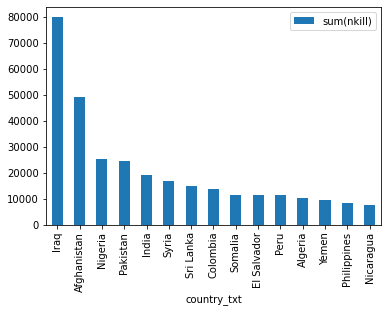

In [24]:
tmp=(final_df.groupby("country_txt").sum("nkill")).toPandas()
tmp.sort_values(ascending=False,by="sum(nkill)")[:15].plot.bar(x="country_txt",y="sum(nkill)")

<AxesSubplot:xlabel='attacktype1_txt'>

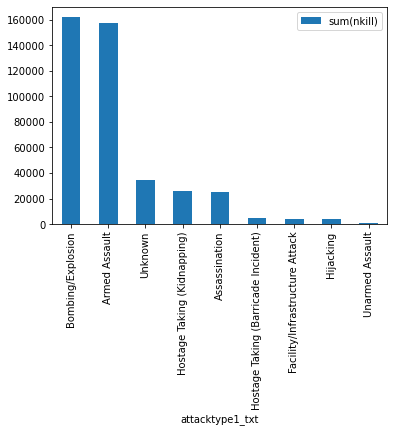

In [25]:
tmp=(final_df.groupby("attacktype1_txt").sum("nkill")).toPandas()
tmp.sort_values(ascending=False,by="sum(nkill)")[:15].plot.bar(x="attacktype1_txt",y="sum(nkill)")

<AxesSubplot:xlabel='target1'>

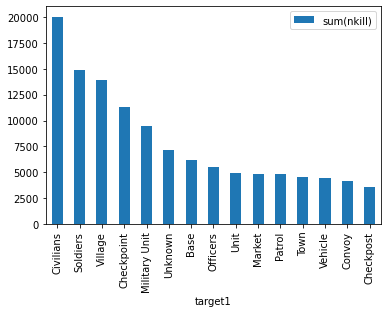

In [26]:
tmp=(final_df.groupby("target1").sum("nkill")).toPandas()
tmp.sort_values(ascending=False,by="sum(nkill)")[:15].plot.bar(x="target1",y="sum(nkill)")

<AxesSubplot:xlabel='targsubtype1_txt'>

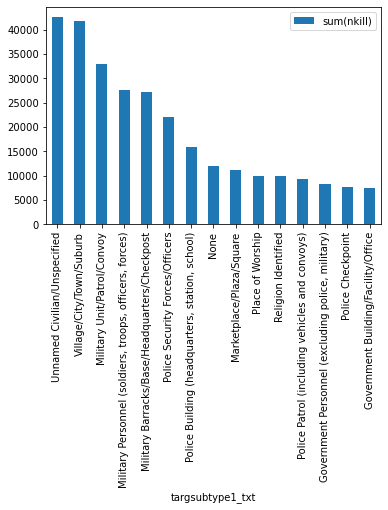

In [27]:
tmp=(final_df.groupby("targsubtype1_txt").sum("nkill")).toPandas()
tmp.sort_values(ascending=False,by="sum(nkill)")[:15].plot.bar(x="targsubtype1_txt",y="sum(nkill)")

In [28]:
tmp=None

Modell építése

1) Transform_data függvény, mely a szöveg és szám típusú oszlopokat külön kezeli -> eredmény: feature és label oszlop, melyekre már lehet a modellt fitelni (hiányos értékek 0-val helyettesítve egyszerűsítés miatt)

2) Label-hez hasonló oszlopok kiszűrése (nkill, nkillus), illetve lehetséges input oszlopok listába gyűjtése és kategorizálása

3) Train-test split

4) Random forest paraméterezés és fitelés

5) Predikciók pandas dataframebe mentése (kiértékelés egyszerűsítése végett)

6) Konfúziós mátrix készítés és input változók fontosságának ábrázolása

In [29]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer,VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [30]:
def transform_data(df,string_cols,num_cols,label):
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, VectorAssembler
    from pyspark.sql.functions import col
    
    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) # Szövegtípusúakhoz indexelés
                for c in string_cols]
    
    #Indexelt oszlopok + numerikus vektorrá alakítása
    assembler = VectorAssembler(inputCols=[indexer.getOutputCol()  for indexer in indexers] 
                                + num_cols, outputCol="features")
    
    #Oszályok indexelése
    labelIndexer = StringIndexer(inputCol=label, outputCol="indexedLabel")  
        
    #Pipeline létrehozása
    pipeline = Pipeline(stages=indexers + [assembler]+[labelIndexer])
    
    #Pipelineban lévő transzformációk fitelése 
    model=pipeline.fit(df)
    
    #Pipelineban lévő transzformációk transzformációja 
    data = model.transform(df)
    
    #indexelt osztályok hozzáadása
    data = data.withColumn('label',col("indexedLabel"))
    
    #hiányos értékek tartalmazó sorok eldobása
    data=data.na.drop()
    
    #Transzformált dataframe 
    return data.select('features','label')

In [31]:
#Célváltozóhoz hasonló oszlopok kiszűrése
exclude=["nkill","nkillus","nkillter","nwound","nwoundte","Kill grouping","target1"]

#Lehetséges inputok
possible_feats=["crit1","crit2","crit3","extended","vicinity","doubtter","multiple","succes","suicide","claimed",
                "property","propextent","propcommet","ishostkid","Specifity","country","region",
                "attcktype1","targtype1","targsubtype1","natlty1","weaptype1","target1"]

#Inputok típusa alapján listába mentés
str_cols = [col.name for col in final_df.schema.fields if 
            (col.name in possible_feats) & (col.name not in exclude) & (isinstance(col.dataType, StringType))
           ]

num_cols = [col.name for col in final_df.schema.fields if 
            (col.name in possible_feats) & (col.name not in exclude) & 
            ((isinstance(col.dataType, IntegerType) | (isinstance(col.dataType, DoubleType)))
             )]
#Célváltozó
y="Kill grouping"

In [32]:
#Lista létrehozása, dataframe leszűréshez
all=[*str_cols,*num_cols,y]

In [33]:
print("Választott inputok a modellhez:'\n' " + '\n'.join(map(str, all[:-1])))

Választott inputok a modellhez:'
' extended
country
region
vicinity
crit1
crit2
crit3
multiple
suicide
targtype1
targsubtype1
natlty1
claimed
weaptype1
property
propextent
ishostkid


In [34]:
data=None
data=final_df.select(all)
data=data.fillna(0)

In [35]:
#Transzformáció
dataset=transform_data(data,[],num_cols,y)

In [36]:
#Train-Test split
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed=123)

In [37]:
rf=None
rf = RandomForestClassifier(labelCol="label", featuresCol="features",
                                 numTrees=50, featureSubsetStrategy="auto",
                                 impurity='gini', maxDepth=12)
rf_model=rf.fit(trainingData)
rf_preds=rf_model.transform(testData)

In [38]:
rf_preds.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(17,[0,1,2,4,5,6,...|  0.0|[25.4397764625937...|[0.50879552925187...|       0.0|
|(17,[0,1,2,4,5,6,...|  0.0|[27.2260892946370...|[0.54452178589274...|       0.0|
|(17,[0,1,2,4,5,6,...|  0.0|[11.6097140232472...|[0.23219428046494...|       1.0|
|(17,[0,1,2,4,5,6,...|  1.0|[12.1803790025223...|[0.24360758005044...|       1.0|
|(17,[0,1,2,4,5,6,...|  0.0|[18.3579767379862...|[0.36715953475972...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [40]:
preds_df=rf_preds.toPandas()

                           precision    recall  f1-score   support

       Halál eset nélküli       0.79      0.78      0.79     17906
Áldozatokkal járó támadás       0.78      0.79      0.78     17118

                 accuracy                           0.78     35024
                macro avg       0.78      0.78      0.78     35024
             weighted avg       0.78      0.78      0.78     35024



<AxesSubplot:>

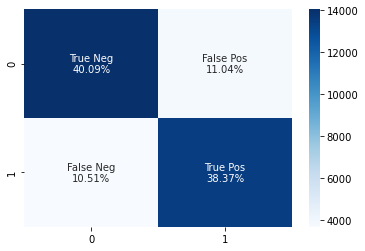

In [41]:
#Konfúziós mátrix létrehozása
cf=confusion_matrix(preds_df["label"], preds_df["prediction"])

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print(classification_report(preds_df["label"],preds_df["prediction"],target_names=classes))

sns.heatmap(cf, annot=labels, fmt="", cmap='Blues')

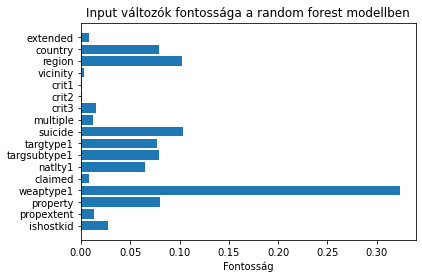

In [42]:
#Input változók fontosságának ábrázolása

fig, ax = plt.subplots()

# Example data
features = all[:-1]
y_pos = np.arange(len(features))
importance = rf_model.featureImportances

ax.barh(y_pos, importance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Fontosság')
ax.set_title('Input változók fontossága a random forest modellben')

plt.show()

Interaktív vizualizáció és ahhoz szükséges lépések:

1) Longitude, latitude átalakítása datashadernek megfelelően

2) Térképhez szükséges oszlopok pandas dataframebe való mentése

3) K-közép klaszterezése, nincs könyökelv alkalmazása -> cél: több kisebb klaszter létrehozása (kijönnek-e a kontinsenkénti megoszlás)

4) Paraméterezett térkép készítés a https://anaconda.org/jbednar/nyc_taxi_panel/notebook minta alapján

In [43]:
from datashader.utils import lnglat_to_meters

In [44]:
#Pandas dataframebe mentés
final_df=final_df.withColumn("longitude", regexp_replace("longitude", ',', '.').cast('float')) 
final_df=final_df.withColumn("latitude", regexp_replace("latitude", ',', '.').cast('float'))
map_df=final_df.select("latitude","longitude").toPandas()
map_df=map_df.rename(columns={"latitude": "Latitude", "longitude": "Longitude"})

In [45]:
#Mercatorrá alakítás
x,y=lnglat_to_meters(map_df.Longitude,map_df.Latitude)

In [46]:
kills=final_df.select("nkill").toPandas()

In [47]:
map_df["x"]=x
map_df["y"]=y
map_df["Deaths"]=kills["nkill"]

In [48]:
from sklearn.cluster import KMeans

In [49]:
# K-közép klaszter, 8 klaszterral
kmeans = KMeans(n_clusters = 8, init ='k-means++')
kmeans.fit(map_df[map_df.columns[0:2]]) 
map_df['Cluster'] = kmeans.fit_predict(map_df[map_df.columns[0:2]])
centers = kmeans.cluster_centers_ 
labels = kmeans.predict(map_df[map_df.columns[0:2]]) 

In [50]:
import param, colorcet, holoviews as hv, geoviews as gv, panel as pn, dask.dataframe as dd
from holoviews.streams import RangeXY
from holoviews.operation.datashader import rasterize, shade
import geoviews.tile_sources as gts

hv.extension('bokeh', logo=False)

df    = map_df
opts  = dict(width=600,height=600,xaxis=None,yaxis=None,bgcolor='black',show_grid=False) #opciók dictionary-be mentése
cmaps = {n: colorcet.palette[n] for n in ['fire','bgy','bgyw','bmy','gray','kbc']} #lehetséges színpalették

class Terrorism(param.Parameterized):
    alpha    = param.Magnitude(default=0.75, doc="Alpha value for the map opacity") #átláthatóság paraméter
    cmap     = param.ObjectSelector(cmaps['fire'], objects=cmaps) #színpaletták paraméter
    cluster = param.ObjectSelector(default='All', objects=[*[x for x in range(0,8)]+["All"]]) #klaszterek paramétere

    @param.depends('cluster') #pontok megjelenítése
    def points(self):
        points = hv.Points(df[df["Cluster"]==self.cluster], kdims=['x', 'y'], vdims=['Cluster'])
        if self.cluster == "All": points = hv.Points(df, kdims=['x', 'y'], vdims=['Deaths'])
        return points

    @param.depends('alpha') #átlátszóság
    def tiles(self):
        return gts.CartoDark.options(alpha=self.alpha, **opts)

    def view(self,**kwargs): #ábrázolás
        points = hv.DynamicMap(self.points)
        agg    = rasterize(points, x_sampling=1, y_sampling=1, width=600, height=400)
        stream = hv.streams.Params(self, ['cmap'])
        tiles  = hv.DynamicMap(self.tiles)
        return tiles * shade(agg, streams=[stream])

terrorism = Terrorism(name="Terrorism geoview")
pn.Row(terrorism.param, terrorism.view()).servable()

PROJ: proj_create_from_database: Cannot find proj.db


Row
    [0] Column(margin=5, name='Terrorism geoview', width=300)
        [0] StaticText(value='<b>Terrorism g...)
        [1] FloatSlider(name='Alpha', value=0.75, value_throttled=0.75)
        [2] Select(name='Cmap', options=OrderedDict([('fire', ...]), value=['#000000', '#060000', ...])
        [3] Select(name='Cluster', options=OrderedDict([('0', ...]), value='All')
    [1] HoloViews(DynamicMap)